In [1]:
import numpy as np
import pandas as pd
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer


In [2]:
Nyt_data = pd.read_csv("C:\\Users\\ftt\\Desktop\\Sem2_NLP_Stats\\NLP\\Final Project\\NYT_Title_Generation-\\NYT_Dataset.csv")

In [3]:
Nyt_data.head()

,Unnamed: 0,ID,title,topic,abstract,Date,keywords
0,0,nyt://article/178801fe-4679-5f12-985f-8344a86e...,"In Reversal, Pakistan Welcomes Outside Help Wi...",Foreign,Pakistan’s ambassador to the U.S. said his gov...,2008-01-01 05:00:00+00:00,['Assassinations and Attempted Assassinations'...
1,1,nyt://article/21acedcb-a7f6-5131-99cf-d3a47e33...,Fighting Intensifies After Election in Kenya,Foreign,"Kenya sank deeper into trouble, with a curfew ...",2008-01-01 05:00:00+00:00,"['Kenya', 'Demonstrations and Riots', 'Odinga,..."
2,2,nyt://article/357b5429-a9f8-5d33-a5eb-c013a201...,Israel: Olmert Curbs Settlements,Foreign,Prime Minister Ehud Olmert has sent a letter t...,2008-01-01 05:00:00+00:00,['West Bank']
3,3,nyt://article/619ca4ea-50e4-59e4-97bb-f206502c...,Gay Muslims Pack a Dance Floor of Their Own,Foreign,The monthly club night known as Gayhane is an ...,2008-01-01 05:00:00+00:00,"['Homosexuality', 'Islam', 'IMMIGRATION AND RE..."
4,4,nyt://article/73c49a5a-bcf1-5b8f-a15a-98d29003...,Iraqi Revelers Embrace the New Year,Foreign,"But even as partygoers embraced the New Year, ...",2008-01-01 05:00:00+00:00,"['ARMAMENT, DEFENSE AND MILITARY FORCES', 'Iraq']"


In [4]:
Nyt_data.columns

Index(['Unnamed: 0', 'ID', 'title', 'topic', 'abstract', 'Date', 'keywords'], dtype='object')

Text(0, 0.5, 'Frequency')

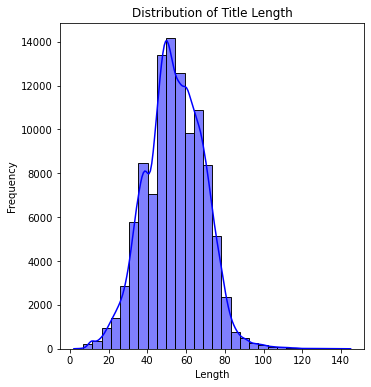

In [ ]:
# Text Length Analysis
Nyt_data['title_length'] = Nyt_data['title'].apply(lambda x: len(str(x)))
Nyt_data['abstract_length'] = Nyt_data['abstract'].apply(lambda x: len(str(x)))

# Visualize distributions of title and abstract lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['title_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Title Length')
plt.xlabel('Length')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

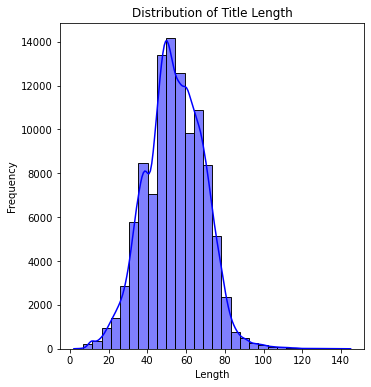

In [ ]:
# Text Length Analysis
Nyt_data['title_length'] = Nyt_data['title'].apply(lambda x: len(str(x)))
Nyt_data['abstract_length'] = Nyt_data['abstract'].apply(lambda x: len(str(x)))

# Visualize distributions of title and abstract lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(Nyt_data['title_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Title Length')
plt.xlabel('Length')
plt.ylabel('Frequency')

In [ ]:
# Length Correlation
correlation = np.corrcoef(Nyt_data['title_length'], Nyt_data['abstract_length'])[0, 1]
print(f"Correlation between title length and abstract length: {correlation}")

Correlation between title length and abstract length: 0.170260173398898


In [ ]:
# Length Correlation
correlation = np.corrcoef(Nyt_data['title_length'], Nyt_data['abstract_length'])[0, 1]
print(f"Correlation between title length and abstract length: {correlation}")

Correlation between title length and abstract length: 0.170260173398898


In [ ]:
# Text Content Analysis
# Word Frequency
def get_most_common_words(text_series, n=10):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text_series)
    word_counts = np.array(X.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names()
    return pd.DataFrame({'word': words, 'count': word_counts}).sort_values('count', ascending=False).head(n)

most_common_title_words = get_most_common_words(Nyt_data['title'])
most_common_abstract_words = get_most_common_words(Nyt_data['abstract'])

print("Most common words in titles:")
print(most_common_title_words)

print("\nMost common words in abstracts:")
print(most_common_abstract_words)


Most common words in titles:
            word  count
5216       china   4757
18411        new   4462
28131      trump   4147
23905       says   3948
9047    election   3040
4707        case   2964
15557     leader   2734
14249       iran   2681
6573       covid   2285
20932  president   2226

Most common words in abstracts:
             word  count
34767   president  14255
38961        said  13425
30670         new   7831
18864  government   7653
33258      people   5910
10675     country   5866
46877      united   5747
28827    minister   5471
42627       state   5460
31570   officials   5289


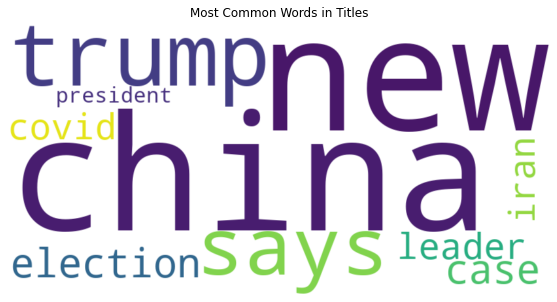

In [ ]:
title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(most_common_title_words['word']))
plt.figure(figsize=(10, 5))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Titles')
plt.axis('off')
plt.show()

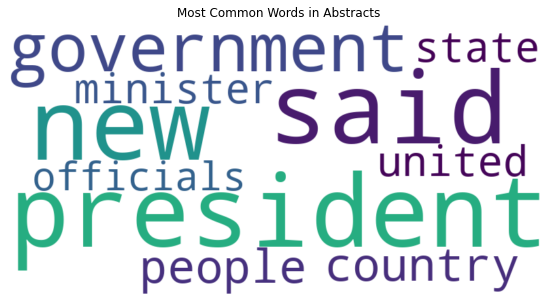

In [ ]:
# Create word cloud for most common words in abstracts
abstract_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(most_common_abstract_words['word']))
plt.figure(figsize=(10, 5))
plt.imshow(abstract_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Abstracts')
plt.axis('off')
plt.show()

In [5]:
Sample_nyt = Nyt_data.sample(frac=0.3)
Sample_nyt.shape

(31952, 7)

In [6]:
import re
def text_strip(column):
    for row in column:
        row=re.sub("(\\t)", ' ', str(row)).lower() 
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        row=re.sub("(__+)", ' ', str(row)).lower()   
        row=re.sub("(--+)", ' ', str(row)).lower()   
        row=re.sub("(~~+)", ' ', str(row)).lower()   
        row=re.sub("(\+\++)", ' ', str(row)).lower()   
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() 
        row=re.sub("(mailto:)", ' ', str(row)).lower() 
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower()
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() 
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() 
        row=re.sub("(\.\s+)", ' ', str(row)).lower() 
        row=re.sub("(\-\s+)", ' ', str(row)).lower() 
        row=re.sub("(\:\s+)", ' ', str(row)).lower()
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower()
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass
        row = re.sub("(\s+)",' ',str(row)).lower() 
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() 
        yield row


In [7]:
stripped_title = text_strip(Sample_nyt['title'])
stripped_abstract = text_strip(Sample_nyt['abstract'])

In [8]:
stripped_title = text_strip(Sample_nyt['title'])
stripped_title_list = list(stripped_title)
len(stripped_title_list)  


31952

In [9]:
stripped_title

<generator object text_strip at 0x000002479AAE3890>

In [9]:
!pip install spacy

     ---------------------------------------- 0.0/107.3 kB ? eta -:--:--
     -------------------------------------- 107.3/107.3 kB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   - -------------------------------------- 0.4/12.1 MB 8.3 MB/s eta 0:00:02
   -- ------------------------------------- 0.8/12.1 MB 8.2 MB/s eta 0:00:02
   --- ------------------------------------ 1.2/12.1 MB 8.1 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/12.1 MB 8.4 MB/s eta 0:00:02
   ------ --------------------------------- 1.9/12.1 MB 8.2 MB/s eta 0:00:02
   ------- -------------------------------- 2.3/12.1 MB 8.7 MB/s eta 0:00:02
   -------- ------------------------------- 2.7/12.1 MB 8.1 MB/s eta 0:00:02
   ---------- ----------------------------- 3.1/12.1 MB 8.3 MB/s eta 0:00:02
   ----------- ---------------------------- 3.6/12.1 MB 8.4 MB/s eta 0:00:02
   ------------ --------------------------- 3.9/12.1 MB 8.6 MB/s eta 0:00:01
   ----


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 320.0 kB/s eta 0:00:40
     --------------------------------------- 0.0/12.8 MB 279.3 kB/s eta 0:00:46
      --------------------------------------- 0.3/12.8 MB 1.6 MB/s eta 0:00:09
     -- ------------------------------------- 0.8/12.8 MB 4.0 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 5.7 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 7.4 MB/s eta 0:00:02
     --------- ------------------------------ 3.0/12.8 MB 8.6 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 9.4 MB/s eta 0:00:01
     -------------- ------------------------- 4.5/12.8 MB 10.3 MB/s eta 0:00:01
     ---------------- ----------------------- 5.2/12.8 MB 10.8 MB/s eta 0:00:01
     ------------------ --------------------- 5.9/12.8 MB 11.1


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from time import time
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 
t = time()
text = [str(doc) for doc in nlp.pipe(stripped_abstract, batch_size=5000)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.59 mins


In [12]:
text[0]

'a dwindling band of veterans began gathering for the 70th anniversary of the amphibious landings in normandy that turned the course of world war ii.'

In [13]:
# Load spacy model
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
stripped_title = text_strip(Sample_nyt['title'])
stripped_title_list = list(stripped_title)
t = time()
title = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(stripped_title_list, batch_size=5000)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2))
# Check the output
print(title[:5]) 


Time to clean up everything: 0.44 mins
['_START_ as d-day tribute nears leaders maneuver over ukraine _END_', '_START_ chinese official defends construction of schools felled in quake _END_', '_START_ irish leader apologizes for adoptions that ‘robbed children’ of their identity _END_', '_START_ beneath mask of normal nigerian life young lives scarred by boko haram _END_', '_START_ share your experiences as female police officer _END_']


In [14]:
Sample_nyt['cleaned_abstract'] = pd.Series(text)
Sample_nyt['cleaned_title'] = pd.Series(title)

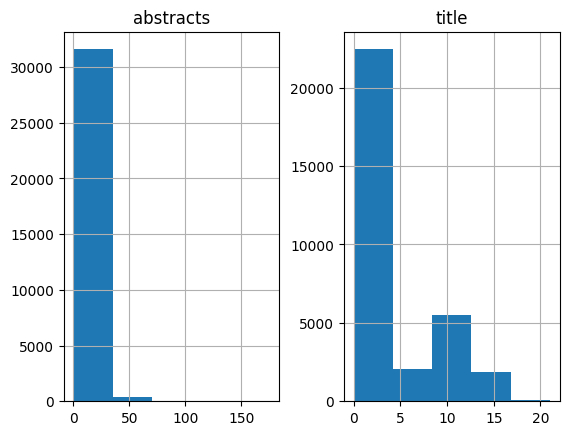

Percentage of titles with 0-15 words: 99.37%
Percentage of abstracts with 0-100 words: 99.98%


In [15]:
abstract_count = []
title_count = []
Sample_nyt['cleaned_abstract'] = Sample_nyt['cleaned_abstract'].fillna('')
Sample_nyt['cleaned_title'] = Sample_nyt['cleaned_title'].fillna('')
for sent in Sample_nyt['cleaned_abstract']:
    abstract_count.append(len(sent.split()))
for sent in Sample_nyt['cleaned_title']:
    title_count.append(len(sent.split()))
graph_df = pd.DataFrame()
graph_df['abstracts'] = abstract_count
graph_df['title'] = title_count
graph_df.hist(bins=5)
plt.show()
cnt = 0
for i in Sample_nyt['cleaned_title']:
    if len(i.split()) <= 15:
        cnt += 1
percentage_titles = cnt / len(Sample_nyt['cleaned_title'])
print(f"Percentage of titles with 0-15 words: {percentage_titles:.2%}")
cnt = 0
for i in Sample_nyt['cleaned_abstract']:
    if len(i.split()) <= 100:
        cnt += 1
percentage_abstracts = cnt / len(Sample_nyt['cleaned_abstract'])
print(f"Percentage of abstracts with 0-100 words: {percentage_abstracts:.2%}")


In [16]:
max_text_len=200
max_summary_len=25
cleaned_text =np.array(Sample_nyt['cleaned_abstract'])
cleaned_summary=np.array(Sample_nyt['cleaned_title'])
short_text=[]
short_summary=[]
for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})


In [17]:
post_pre.head(50)

,text,summary
0,,
1,the market where an attack killed 12 people on...,_START_ shaken but undaunted berliners return ...
2,,
3,,
4,,
5,,
6,corey lewandowski trump campaign adviser who h...,_START_ corey lewandowski trump campaign advis...
7,,
8,,
9,,


In [18]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [21]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [22]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0
for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_voc   =  x_tokenizer.num_words + 1
print("Size of vocabulary in X = {}".format(x_voc))

% of rare words in vocabulary: 70.07693129607864
Total Coverage of rare words: 9.156199158690841
Size of vocabulary in X = 5602


In [23]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))
thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0
for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))
#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 
#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 81.69161155586495
Total Coverage of rare words: 10.809761582843604
Size of vocabulary in Y = 2105


In [24]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)
y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)


In [25]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [26]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
print("Size of vocabulary from the w2v model = {}".format(x_voc))
K.clear_session()
latent_dim = 300
embedding_dim=200
encoder_inputs = Input(shape=(max_text_len,))
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


Size of vocabulary from the w2v model = 5602



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 200)  │  1,120,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 200,      │    601,200 │ embedding[0][0]   │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 200,      │    721,200 │ lstm[0][0]        │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 200) │    421,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 200,      │    721,200 │ lstm_1[0][0]      │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    601,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │    633,605 │ lstm_3[0][0]      │
│ (TimeDistributed)   │ 2105)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,819,805 (18.39 MB)

 Trainable params: 4,819,805 (18.39 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [29]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 396s 6s/step - loss: 3.7630 - val_loss: 2.0333
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 439s 6s/step - loss: 2.0618 - val_loss: 1.9100
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 457s 7s/step - loss: 1.9502 - val_loss: 1.8911
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 462s 7s/step - loss: 1.9500 - val_loss: 1.8846
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 473s 7s/step - loss: 1.9289 - val_loss: 1.8761
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 475s 7s/step - loss: 1.9358 - val_loss: 1.8808
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 480s 7s/step - loss: 1.9162 - val_loss: 1.8715
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 485s 7s/step - loss: 1.9235 - val_loss: 1.8679
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 494s 7s/step - loss: 1.9098 - val_loss: 1.8674
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 499s 7s/step - loss: 1.9081 - val_loss: 1.8557
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 503s 7s/step - loss: 1.9056 - val_loss: 1.8462
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 589s 9s/step - loss: 1.8

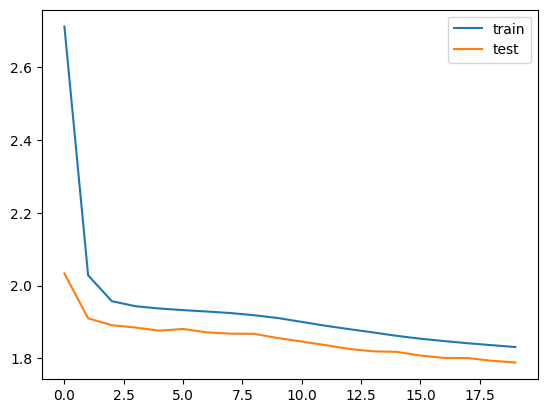

In [30]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**build the dictionary to convert the index to word for target and source vocabulary:**

In [33]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [37]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [38]:
for i in range(0,2):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: all six unesco world heritage sites in syria had been damaged in that country’s war including the most recent destruction in the ancient city of palmyra 
Original summary: start still at risk experts warn end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted summary:  start in the the the end


Review: officials have been discussing the date venue and agenda for discussions between president trump and kim jong un said president moon jae in of south korea 
Original summary: start u s and north korea in talks on trump kim meeting south says end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [40]:
!pip install rouge


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import numpy as np

In [42]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import numpy as np

# Initialize ROUGE scorer
rouge_scorer = Rouge()

# Placeholder for scores
bleu_scores = []
rouge_scores = []

# Assuming you have a validation set or test set that you can use
for i in range(len(x_val)):
    input_seq = x_val[i].reshape(1, max_text_len)
    summary = seq2summary(y_val[i]).strip()
    predicted_summary = decode_sequence(input_seq).strip()
    
    print(f"Original summary: {summary}")
    print(f"Predicted summary: {predicted_summary}")
    
    # Calculate BLEU score
    reference = summary.split()
    candidate = predicted_summary.split()
    score = sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25)) # You can adjust weights
    bleu_scores.append(score)
    
    # Calculate ROUGE score
    rouge_score = rouge_scorer.get_scores(predicted_summary, summary)
    rouge_scores.append(rouge_score[0])  # [0] because get_scores returns a list of scores

# Average the BLEU and ROUGE scores across all predictions
average_bleu = np.mean(bleu_scores)
average_rouge = {
    'rouge-1': np.mean([score['rouge-1']['f'] for score in rouge_scores]),
    'rouge-2': np.mean([score['rouge-2']['f'] for score in rouge_scores]),
    'rouge-l': np.mean([score['rouge-l']['f'] for score in rouge_scores]),
}

print(f"Average BLEU score: {average_bleu:.4f}")
print(f"Average ROUGE-1 score: {average_rouge['rouge-1']:.4f}")
print(f"Average ROUGE-2 score: {average_rouge['rouge-2']:.4f}")
print(f"Average ROUGE-L score: {average_rouge['rouge-l']:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Original summary: start india’s coronavirus lockdown leaves numbers and end
Predicted summary: start in the the the end
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Original summary: start transcript from lost jet is released by malaysia end
Predicted summary: start in the the the end
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/s

In [59]:
!pip install nltk rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=3104605b4607306ea19bca1222b2f24ce06f01f8fb17ac8648f3934dfef28008
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [61]:
import nltk
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

nltk.download('punkt')

def calculate_scores(reference, candidate):
    reference_tokens = nltk.word_tokenize(reference)
    candidate_tokens = nltk.word_tokenize(candidate)
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, candidate) 
    return bleu_score, rouge_scores
# Calculate scores
bleu_score, rouge_scores = calculate_scores(reference_text, generated_text)
print("BLEU Score:", bleu_score)
print("ROUGE Scores:", rouge_scores)

BLEU Score: 0.5253819788848316
ROUGE Scores: {'rouge1': Score(precision=0.8888888888888888, recall=0.8888888888888888, fmeasure=0.8888888888888888), 'rouge2': Score(precision=0.875, recall=0.875, fmeasure=0.875), 'rougeL': Score(precision=0.8888888888888888, recall=0.8888888888888888, fmeasure=0.8888888888888888)}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**TRANSFORMERS T5**

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [ ]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

# Preparing Data For T5 

In [ ]:
from google.colab import drive
# mount your drive to colab where your dataset is present
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://huggingface.co/datasets/valurank/News_headlines

Cloning into 'News_headlines'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (14/14), 1.49 MiB | 6.38 MiB/s, done.


In [ ]:
!unzip /content/NYT.zip

unzip:  cannot find or open /content/NYT.zip, /content/NYT.zip.zip or /content/NYT.zip.ZIP.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NYT_Dataset.csv", encoding="latin-1")
df = df.dropna()
df = df[['title','abstract']]
df.head()

,title,abstract
0,"In Reversal, Pakistan Welcomes Outside Help Wi...",Pakistanâs ambassador to the U.S. said his g...
1,Fighting Intensifies After Election in Kenya,"Kenya sank deeper into trouble, with a curfew ..."
2,Israel: Olmert Curbs Settlements,Prime Minister Ehud Olmert has sent a letter t...
3,Gay Muslims Pack a Dance Floor of Their Own,The monthly club night known as Gayhane is an ...
4,Iraqi Revelers Embrace the New Year,"But even as partygoers embraced the New Year, ..."


In [ ]:
df =df.sample(frac=0.05).reset_index(drop=True)

In [ ]:

train_df, rest_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(rest_df, test_size=0.5)

train_df = train_df.head()
test_df = test_df.head()
val_df = val_df.head()
train_df.shape, test_df.shape

((5, 2), (5, 2))

In [ ]:
MODEL_NAME = "t5-base" #smallest t5 model

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length=512) # , model_max_length=10000

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
article_token_counts, headline_token_counts = [], []

for _, row in train_df.iterrows():
    article_token_count = len(tokenizer.encode(row["abstract"]))
    article_token_counts.append(article_token_count)

    headline_token_count = len(tokenizer.encode(row["title"]))
    headline_token_counts.append(headline_token_count)

In [ ]:
df["abstract"].str.len().max(), df["title"].str.len().max()

(607, 131)

Text(0.5, 1.0, 'headline text token counts')

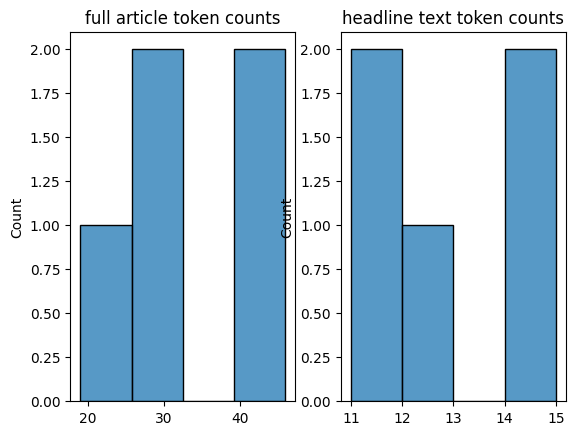

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(article_token_counts, ax=ax1)
ax1.set_title("full article token counts")

sns.histplot(headline_token_counts, ax=ax2)
ax2.set_title("headline text token counts")

In [ ]:
example = df.iloc[0]["abstract"]
example

'The prime ministerâ\x80\x99s comment dimmed the prospects for an imminent deal to release Cpl. Gilad Shalit, but he pledged to continue rescue efforts.'

In [ ]:
class NewsHeadlineDataset(Dataset):

    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        article_max_token_len: int = 512,
        headline_max_token_len: int = 128
    ):

        self.tokenizer = tokenizer
        self.data = data
        self.article_max_token_len = article_max_token_len
        self.headline_max_token_len = headline_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        article = data_row["abstract"]

        article_encoding = tokenizer(
            article,
            max_length=self.article_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        headline_encoding = tokenizer(
            data_row["title"],
            max_length=self.headline_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        labels = headline_encoding["input_ids"]
        labels[labels == 0] = -100

        return dict(
            article=article,
            headline=data_row["title"],
            article_input_ids=article_encoding["input_ids"].flatten(),
            article_attention_mask=article_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=headline_encoding["attention_mask"].flatten()
        )

In [ ]:
class NewsHeadlineDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        val_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        article_max_token_len: int = 512,
        headline_max_token_len: int = 128
    ):

        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.article_max_token_len = article_max_token_len
        self.headline_max_token_len = headline_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewsHeadlineDataset(
            self.train_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

        self.test_dataset = NewsHeadlineDataset(
            self.test_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

        self.val_dataset = NewsHeadlineDataset(
            self.val_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

# Model Building

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 8

data_module = NewsHeadlineDataModule(train_df, test_df, val_df, tokenizer, batch_size=BATCH_SIZE)

In [ ]:
class NewsHeadlineModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        self.val_loss = []
        self.val_loss_epoch = []

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.val_loss.append(loss)
        return loss

    def on_validation_epoch_end(self):
      avg = sum(self.val_loss)/len(self.val_loss)
      self.val_loss_epoch.append(avg)
      self.val_loss = []
    def test_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

In [ ]:
model = NewsHeadlineModel()

In [ ]:
!mkdir /content/checkpoints

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EPOCHS,

)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_loss' reached 4.59518 (best 4.59518), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2: 'val_loss' reached 4.17685 (best 4.17685), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3: 'val_loss' reached 3.97304 (best 3.97304), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4: 'val_loss' reached 3.84547 (best 3.84547), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5: 'val_loss' reached 3.77119 (best 3.77119), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6: 'val_loss' reached 3.71830 (best 3.71830), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7: 'val_loss' reached 3.67520 (best 3.67520), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8: 'val_loss' reached 3.64064 (best 3.64064), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 9: 'val_loss' reached 3.61593 (best 3.61593), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 10: 'val_loss' reached 3.60006 (best 3.60006), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
a = model.val_loss_epoch

In [ ]:
a = torch.Tensor(a).cpu()

In [ ]:
custom_path = "/content/checkpoints/best-checkpoint.ckpt"
trained_model = NewsHeadlineModel.load_from_checkpoint(custom_path)
trained_model.freeze()

In [ ]:

def generate_headline(text):
  text_encoding = tokenizer(
      text,
      max_length=512,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
  )
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  input_ids = text_encoding["input_ids"].to(device)
  attention_mask = text_encoding["attention_mask"].to(device)

  generated_ids = trained_model.model.generate(
      input_ids=text_encoding["input_ids"],
      attention_mask=text_encoding["attention_mask"],
      max_length=150,
      num_beams=2, # beam search
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True # To speed up the process
  )

  preds = [
      tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
      for gen_id in generated_ids
  ]

  return "".join(preds)

In [ ]:
def generate_headline(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )
    input_ids = text_encoding["input_ids"]
    attention_mask = text_encoding["attention_mask"]
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    generated_ids = trained_model.model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]

    return "".join(preds)


## Prediction examples

In [ ]:
sample_row = val_df.iloc[3]
text = sample_row["abstract"]
text="Few places have been so thoroughly gutted by the post-election violence in Kenya as Kisumu,  the country’s third-largest city. "

In [ ]:
sample_row

title                      1914: 79 Die in Brutal German Raid
abstract    From the International Herald Tribune archives...
Name: 4618, dtype: object

In [ ]:
print(len(text.split()))
text

24


'From the International Herald Tribune archives: A German raid on English coastal towns launched a wave of enlistments in the armed forces in 1914.'

In [ ]:
sample_row["title"]

'1914: 79 Die in Brutal German Raid'

In [ ]:
generate_headline(text)

'Kisumu, Kenya’s third-largest city, has been devastated by post-election violence.'

In [ ]:
print(len(text.split()))
text

In [ ]:
sample_row["headline"]

In [ ]:
generate_headline(text)

## Rouge Evaluation

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
ROUGE = Rouge()

In [ ]:
sample_row = val_df.iloc[3]
text = sample_row["abstract"]
reference = sample_row["title"]
candidate = generate_headline(text)

In [ ]:
x = ROUGE.get_scores(candidate, reference)
x[0]

{'rouge-1': {'r': 0.2857142857142857, 'p': 0.125, 'f': 0.17391303924385643},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.14285714285714285, 'p': 0.0625, 'f': 0.0869565175047261}}

In [ ]:
type(x[0]["rouge-1"])

dict

In [ ]:
len(val_df.index)


5

In [ ]:
res = {}
res['rouge-1'] = {}
res['rouge-2'] = {}
res['rouge-l'] = {}
for key in res:
  res[key]['r'] = 0
  res[key]['p'] = 0
  res[key]['f'] = 0
for index in range(len(val_df.index)):
  sample_row = val_df.iloc[index]
  text = sample_row["abstract"]
  reference = sample_row["title"]
  candidate = generate_headline(text)
  score = ROUGE.get_scores(candidate, reference)
  for key in res:
    res[key]['r'] += score[0][key]['r']
    res[key]['p'] += score[0][key]['p']
    res[key]['f'] += score[0][key]['f']
for key in res:
  res[key]['r'] /= len(val_df.index)
  res[key]['p'] /= len(val_df.index)
  res[key]['f'] /= len(val_df.index)
res

{'rouge-1': {'r': 0.17103174603174603,
  'p': 0.0746923076923077,
  'f': 0.10358365797024438},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.14246031746031745,
  'p': 0.06219230769230769,
  'f': 0.08619235362241831}}

## Semantic Similarity

In [ ]:
for index in range(len(val_df.index)):
  sample_row = val_df.iloc[index]
  text = sample_row["abstract"]
  reference = sample_row["title"]
  candidate = generate_headline(text)
  with open("predictions.txt","a+") as f:
    f.write(candidate+"\n")

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.8 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
cosine_similarity = 0
dot_product = 0
with open("predictions.txt", "r") as f:
  lines = f.readlines()
  lines = [line.strip() for line in lines]
  for index, line in enumerate(lines):
     sample_row = val_df.iloc[index]
     reference = sample_row["title"]
     en_1 = sentence_model.encode(reference)
     en_2 = sentence_model.encode(line)
     cosine_sim_result = util.cos_sim(en_1, en_2)
     cosine_sim_result_float = cosine_sim_result.item()
     dot_product_result = util.dot_score(en_1, en_2)
     dot_product_result_float = dot_product_result.item()
     cosine_similarity += cosine_sim_result_float
     dot_product += dot_product_result_float
  cosine_similarity /= len(val_df.index)
  dot_product /= len(val_df.index)
print(f'Cosine Similarity: {cosine_similarity} \nDot Product: {dot_product}')

Cosine Similarity: 0.3480244606733322 
Dot Product: 0.3480244517326355
